In [ ]:
import os
from ultralytics import YOLO, trackers
import cv2
import os
import supervision as sv
import cv2
import numpy as np
from ultralytics.data.annotator import auto_annotate
import torch


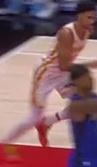

In [2]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image

def convert_to_base64(pil_image):
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))


file_path = "./cropped/magicVShawks.mp4--405d13a9-78fb-43a6-862d-c708e8d787ad.jpg"
pil_image = Image.open(file_path)

image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [3]:
from langchain_core.messages import HumanMessage
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser

llm = ChatOllama(model="llava-llama3", temperature=0)

def prompt_func(data):
    text = data["text"]
    image = data["image"]

    image_part = {
        "type": "image_url",
        "image_url": f"data:image/jpeg;base64,{image}",
    }

    content_parts = []

    text_part = {"type": "text", "text": text}

    content_parts.append(image_part)
    content_parts.append(text_part)

    return [HumanMessage(content=content_parts)]


chain = prompt_func | llm | StrOutputParser()

query_chain = chain.invoke(
    {"text": "Examine the provided image of a basketball player and extract the jersey number. If the jersey number is clearly visible and unambiguous, output only the numeric digits corresponding to the jersey number, with no additional text or explanation. If the jersey number is not clearly identifiable (e.g., due to blurriness or other quality issues), do not guess or generate a number; instead, output nothing", "image": image_b64}
)

print(query_chain)

4


In [ ]:
import base64
from openai import OpenAI

client = OpenAI()

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

image_path = "./cropped/magicVShawks.mp4--0c95c3b1-9820-4782-949e-a58960573f92.jpg"

base64_image = encode_image(image_path)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    response_format={"type": "json_object"},  
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Analyze the basketball player's jersey in the image. Extract ONLY the numerical jersey number. Return JSON: { 'jerseyNumber': number | 'undefined' }. IT IS CRUCIAL TO RETURN 'undefined' IF NO NUMBER IS VISIBLE.",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        }
    ],
)

print(response.choices[0])

In [ ]:
import json
json_data = json.loads(response.choices[0].message.content)
print(json_data['jerseyNumber'])

In [ ]:
import cv2
import os
from utils import log
from tqdm import tqdm  
import matplotlib.pyplot as plt

if __name__ == '__main__':
    os.system('cls' if os.name == 'nt' else 'clear')
    frames = []
    cropped_dir = "./cropped"
    
    for img_file in os.listdir(cropped_dir):
        frame = cv2.imread(os.path.join(cropped_dir, img_file))
        frames.append({
            "frame": frame,
            "file_name": img_file
        })

    try:
        for index, frame_data in enumerate(frames):
            cv2.imshow("Frame", frame_data["frame"])
            key = cv2.waitKey(0) & 0xFF  # Wait for a key press
            cv2.destroyAllWindows()
            
            if key == ord('y') or key == ord('Y'):
                file_path = os.path.join(cropped_dir, frame_data["file_name"])
                try:
                    os.remove(file_path)
                    log(f"Deleted: {frame_data['file_name']}")
                except Exception as e:
                    log(f"Error deleting {frame_data['file_name']}: {e}")
                
                
    except Exception as e:
        log(f"Error occurred: {e}")

In [ ]:
import time
import torch
import cv2
import os
from ultralytics import YOLO
import easyocr
import uuid

import matplotlib.pyplot as plt
reader = easyocr.Reader(['en'])

device = "cuda" if torch.cuda.is_available() else "cpu"

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

model_path = os.path.join('runs/detect/train16/weights', 'best.pt')
model = YOLO(model_path, verbose=False)

input_video_path = './test/big_input.mp4'
output_video_path = './test/output.mp4'

cap = cv2.VideoCapture(input_video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))

frame_interval = int(fps * 0.1)

frame_count = 0
saved_frame_count = 0

out = cv2.VideoWriter(
    output_video_path,
    cv2.VideoWriter_fourcc(*'MP4V'),
    fps,
    (frame_width, frame_height)
)

frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % frame_interval == 0:
        original_frame = frame.copy()
        results = model.predict(frame, device=device, verbose=False)
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = box.conf[0].item()
                cls = int(box.cls[0].item())
                
                label = f"{model.names[cls]} {conf:.2f}"
                
                croped = original_frame[y1:y2, x1:x2]
                results = reader.readtext(croped, detail=0)
                if(model.names[cls] == "player"):
                    cv2.imwrite(f'./cropped/{uuid.uuid4()}.png', croped)
            
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        frames.append(original_frame)
    frame_count += 1

 
cap.release()
out.release()

In [ ]:
import cv2
import easyocr
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("./test.png")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Optional: Apply adaptive thresholding to enhance contrast
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)

# Visualize the preprocessed image
plt.imshow(thresh, cmap='gray')
plt.title("Preprocessed Image for EasyOCR")
plt.show()

# Initialize EasyOCR reader (for English)
reader = easyocr.Reader(['en'])

# Perform OCR on the preprocessed image
results = reader.readtext(thresh, detail=1, paragraph=False)

# Extract only the text portions that contain digits
detected_numbers = [text for bbox, text, conf in results if text.isdigit()]

print("Detected jersey number(s) (EasyOCR):", detected_numbers)


In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import os
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
from sklearn.preprocessing import StandardScaler

model = EfficientNetB4(weights='imagenet', include_top=False, pooling='avg')


def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array, verbose=0)
    return features.flatten()

folder_path = './cropped'
features_list = []
img_paths = []

for img_file in os.listdir(folder_path):
    if img_file.endswith(('.jpg', '.png')):
        img_path = os.path.join(folder_path, img_file)
        img_paths.append(img_path)
        features = extract_features(img_path)
        features_list.append(features)

features_array = np.array(features_list)

# import umap
# reducer = umap.UMAP(n_components=50, random_state=42)
# features_reduced = reducer.fit_transform(features_scaled)

# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
# clusters = clusterer.fit_predict(features_scaled)

from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_neighbors=10)
clusters = clustering.fit_predict(features_array)

k = 10  
# kmeans = KMeans(n_clusters=k, random_state=42)
# clusters = kmeans.fit_predict(features_array)



score = silhouette_score(features_array, clusters)
print(f"Silhouette Score: {score:.2f}")

output_folder = './kmeans'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for cluster_num in range(k):
    cluster_folder = os.path.join(output_folder, f'cluster_{cluster_num}')
    if not os.path.exists(cluster_folder):
        os.makedirs(cluster_folder)

    idxs = [i for i, label in enumerate(clusters) if label == cluster_num]
    for i, idx in enumerate(idxs):
        img = cv2.imread(img_paths[idx])
        img_name = os.path.basename(img_paths[idx])
        save_path = os.path.join(cluster_folder, img_name)
        cv2.imwrite(save_path, img)

print(f"Imagens salvas em {output_folder}")